**Goal: Use the Bader 2020 dataset to train a ML model to test whether NPTX2 (identified as AD biomarker in Shen 2024, Cell) can be used to predict whether a patient has AD using CSF samples**

*Pre-processing of the data: This was an initial big obstacle for me. I might have broken some data science rules at this stage but there were three main issues I identified in the original Excel spreadsheet found in the paper:*

    1. The 1st spreadsheet in the supplementary info of the paper had all the protein abundances from the ~200 patients. However, there was no other information in this spreadsheet about the patients (not even disease status). Information about the patients was in a 2nd spreadsheet. 
    This second spreadsheet contained all the information including age, disease status, collection site, and gender. However, some patients had been deleted so that this 2nd spreadsheet had fewer patients. I had to go through and match up the patients using 'sample name'.
    
    2. Missing values - a couple of the patients had missing values for NPTX2 (written as 'filtered'. I initially tried changing this to 'NA' - but k-NN didn't like this, so instead I just deleted the values. I realise this is probably bad practice as is can skew the data, but I figured it was just 2 values and I was more focused on getting the model to work)
    
    3. In the 1st spreadsheet (proteomics dataset), 1000s proteins were all listed, with each protein in a separate row and each patient (with codified 'sample name') in a separate column. I'm not sure whether I did the right thing here but I didn't think it was right to add the 'age', 'AD status' etc. features as rows - I thought these should be columns. Therefore, I decided to just take the NPTX2 row and transpose it into a column. From this, I created a table where rows = patients and columns = features (AD status, NPTX2 abundance, age, gender). 
    
*These processing steps produced the .xlsx file I used for all analysis in this notebook (Sheet1 of https://github.com/biochembryony/DataScienceAdvocate/blob/main/EMBO_Bader_2020_AD_proteomics_NPTX2_tidy.xlsx)

**Worked example of analysis**

Importing pandas and reading Excel file (might be different if is e.g. a CSV from GitHub)

In [1]:
import pandas as pd

In [2]:
NPTX2_tidy = pd.read_excel("EMBO_Bader_2020_AD_proteomics_NPTX2_tidy.xlsx")

In [3]:
NPTX2_tidy.head()

,Patient,Age,Gender,Collection site,AD status,NPTX2 abundance,sample name
0,Patient 1,71,f,Sweden,control,226437.734375,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
1,Patient 2,77,m,Sweden,AD,123887.046875,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
2,Patient 3,75,m,Sweden,AD,391305.937500,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
3,Patient 4,72,f,Sweden,AD,296838.531250,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
4,Patient 5,63,f,Sweden,AD,211497.703125,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...


Importing seaborn and visualising data

In [4]:
import seaborn as sns

Visualising the data (comparing NPTX2 abundance in control vs AD groups):

**Suggested question: Open the data in Jupyter Notebooks. Use a suitable plot to visualise the distribution of NPTX2 abundance between the control and AD patients. What do you notice?**

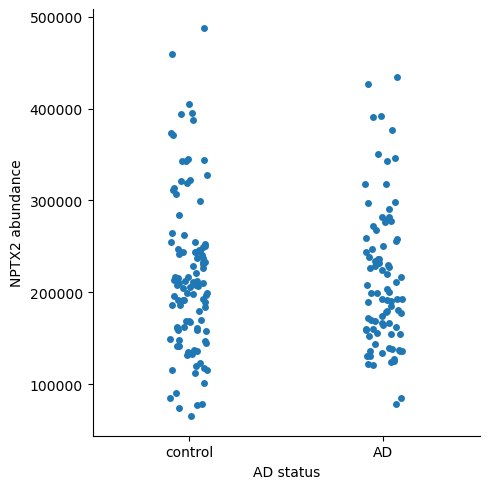

In [5]:
sns.catplot(data=NPTX2_tidy, x="AD status", y="NPTX2 abundance")

From this initial glance, it is apparent that the two groups have pretty similar distribution of NPTX2 abundance, which already indicates early on that this may not be a good biomarker for AD status in this dataset. Could ask students some more questions about that here.

Now checking a few things about the data - e.g. are the different variables the correct type of data; how are the different data distributed (e.g. AD status, age, within different collection sites)

In [6]:
NPTX2_tidy.dtypes #Checking data types. Object = categorical

Patient             object
Age                  int64
Gender              object
Collection site     object
AD status           object
NPTX2 abundance    float64
sample name         object
dtype: object

In [7]:
x=NPTX2_tidy["AD status"]
y=NPTX2_tidy["NPTX2 abundance"]

In [8]:
NPTX2_tidy.value_counts(x) 

AD status
control    108
AD          87
dtype: int64

*More AD than control patients - does this matter?*

In [9]:
NPTX2_tidy.groupby(by=["AD status"]).mean() #Grouping by AD status to see how all numerical conditions vary across AD vs control

/var/folders/3s/w3gsthj94m31b9mclksddvw40000gq/T/ipykernel_16377/502040442.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  NPTX2_tidy.groupby(by=["AD status"]).mean() #Grouping by AD status to see how all numerical conditions vary across AD vs control


,Age,NPTX2 abundance
AD status,,
AD,71.885057,214289.209052
control,64.407407,217592.649342


Looking at the mean ages and NPTX2 abundances shows that the NPTX2 is very similar between the 2 groups (as mentioned earlier). Also, there is difference in age between the two groups - does this matter? How might this affect our interpretation of the data?

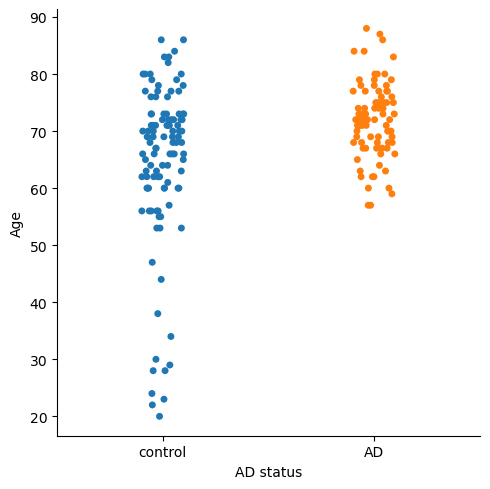

In [10]:
sns.catplot(data=NPTX2_tidy, x="AD status", y="Age", hue="AD status")

This scatterplot also shows that the control group has a population of younger patients not present in the AD group. Let's see if that population clusters with another variable (e.g. collection site)

In [11]:
pd.crosstab(index=NPTX2_tidy["AD status"], columns=NPTX2_tidy["Gender"]) #The cross-tabulation allows you to look at the frequency distribution of multiple categorical variables, and see how they are related to one another

Gender,f,m
AD status,,
AD,48,39
control,50,58


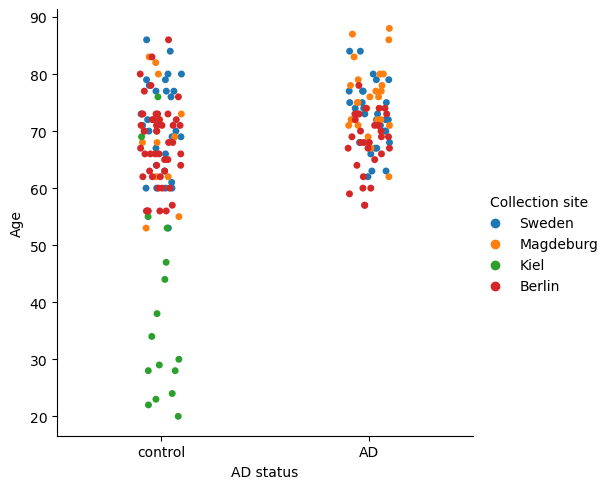

In [12]:
sns.catplot(data=NPTX2_tidy, x="AD status", y="Age", hue="Collection site")

In [13]:
pd.crosstab(index=NPTX2_tidy["AD status"], columns=NPTX2_tidy["Collection site"])

Collection site,Berlin,Kiel,Magdeburg,Sweden
AD status,,,,
AD,32,0,26,29
control,50,16,12,30


*This shows that all of the patients from the Kiel subset are control -- there are no AD patients -- and this cohort is disproportionately younger than the other chorts. This is an interesting observation and spark some interesting questions / other tasks (e.g. should we exclude these values and why? Repeat the model fitting etc without these data - does that affect your result? Students (or I!) could dig into the paper a bit more and find out the differences between the collection site cohorts and use more contextual information to interpret whether this difference matters to the overarching biological question)*

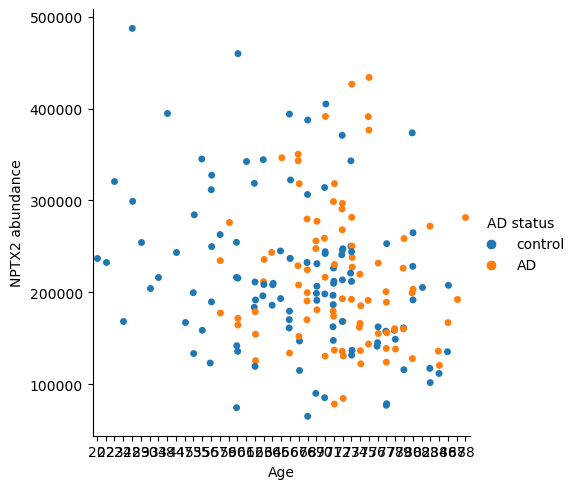

In [14]:
sns.catplot(data=NPTX2_tidy, x="Age", y="NPTX2 abundance", hue="AD status")

*It's around here I got a bit stuck with how to apply the ML models we were taught in the main course. In the example using K-NN, there are x1 and x2 values and y is 0 or 1 (equivalent here to control or AD). However, to answer the proposed question of whether we can use NPTX2 abundance to predict disease status, we only need x1 (no x2). This made me unsure what ML model we should use - or if there even is an appropriate one. 
Other things I considering looking at were correlation between 2 different biomarkers (as x1 and x2), or also factoring age of patient into the predictive model. This makes some sense to me, as age is of course a risk factor for AD - but I'm not sure if this is misusing the data (especially as the control samples are overrepresented by younger patients).*

*Despite these hesitations, I've gone ahead and tried the k-NN approach with the both age and NPTX2 abundance as features (X)*

In [15]:
df = pd.DataFrame(NPTX2_tidy)
df.head()

,Patient,Age,Gender,Collection site,AD status,NPTX2 abundance,sample name
0,Patient 1,71,f,Sweden,control,226437.734375,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
1,Patient 2,77,m,Sweden,AD,123887.046875,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
2,Patient 3,75,m,Sweden,AD,391305.937500,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
3,Patient 4,72,f,Sweden,AD,296838.531250,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
4,Patient 5,63,f,Sweden,AD,211497.703125,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...


To use ML models, we need to encode our data into a binary form which the algorithms can process

In [16]:
df_encoded = pd.get_dummies(df["AD status"])
df_encoded .head()

,AD,control
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


Now concatenating the two data frames:

In [17]:
binary = pd.concat([df_encoded, df], axis=1)
binary.head()

,AD,control,Patient,Age,Gender,Collection site,AD status,NPTX2 abundance,sample name
0,0,1,Patient 1,71,f,Sweden,control,226437.734375,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
1,1,0,Patient 2,77,m,Sweden,AD,123887.046875,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
2,1,0,Patient 3,75,m,Sweden,AD,391305.937500,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
3,1,0,Patient 4,72,f,Sweden,AD,296838.531250,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...
4,1,0,Patient 5,63,f,Sweden,AD,211497.703125,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...


<Axes: xlabel='Age', ylabel='NPTX2 abundance'>

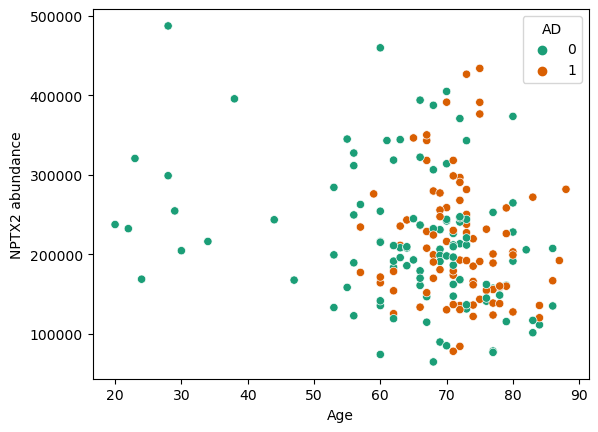

In [18]:
sns.scatterplot(data=binary, x="Age", y="NPTX2 abundance", hue="AD", palette="Dark2")

*Observation: data looks very clustered (apart from the young patients). I don't think there's much of a correlation between AD status and NPTX2 abundance so a model trying to predict AD status from this data will probably be pretty unreliable. But hopefully this can lead to interesting questions for students.*

**Suggested question: Patient y is 70 years of age and a CSF sample sent for proteomics analysis shows that their relative NPTX2 abundance is 297500. Does your model predict that this patient has Alzheimer's disease?**

*I don't think proteomics data tends to come with units - it's more of a relative abundance. But this seems like a likely source of variation between different datasets, which I'd think is problematic for a potential biomarker... note to self: look more into this. Are there ever units? How can there be consistency between different experiments?*

In [19]:
X = binary[["Age", "NPTX2 abundance"]]
y = binary["AD"]

In [20]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=10)

I am asking the question "Is patient y 0 or 1 (negative or positive) for AD?"

In [22]:
pred = pd.DataFrame({"Age": [70], "NPTX2 abundance":[297500]})  # Make a new DataFrame containing the X values
pred["AD"] = model.predict(pred)  # Make a prediction and add that data into the table
pred

,Age,NPTX2 abundance,AD
0,70,297500,0


**Suggested question: Now test the reliability of your model. What is your model score? Would you use this model on real patients? Comment on the quality of the data you used in this exercise**

Now testing the model:

In [23]:
model.score(test_X, test_y)

0.4897959183673469

*Final reflections:*

*1. Unreliable model*

*2. Even if the model were reliable, a more sophisticated / useful example would be to predict disease progression (Expected Years to Onset or EYO). However, this would require temporal data which we don't have here - we only have a binary control or AD.*

*3. Could try a different biomarker -- or ask students to try a different biomarker from the Cell paper (e.g. SMOC1, SMOC2, GFAP, TNFRSF1B, PEA15)*

*4. This exercise might be slightly unrealistic as, in the clinic, a doctor wouldn't be doing proteomics but would instead be doing a targeted test for a specific protein. But I think it's ok as an exercise, especially if the background to the question frames this as an investigation to test the hypothesis that NPTX2 is a good biomarker for sAD, rather than e.g. 'a patient comes into a hospital')*